# Voice Activity Detection Using Permutation Entropy

## Voice Activity Detection

Voice activity detection is the process of determining areas of speech v. non-speech in an audio signal. Some researchers call this "Speech Activity Detection", and further refine Voice Activity Detection to differentiate voiced v. unvoiced parts of speech. I am not going to do this, even though one of the papers this notebook is based on does.

### Why Is It Needed?

So what is a VAD good for? Ask your Amazon Echo, or Google Home, or your phone. Voice activity detection reduces the computational cost of audio analysis. That saves power, and reduces the hardware requirements for devices, allowing cheap, pervasive hardware in your home and pocket to spy on your every utterance.

VAD lets a voice assistant consume little power while nobody is speaking. When it detects voice, the assistant can channel that audio to its activation word comparison system. Once the activation word is detected, the assistant can stream the audio to its home server farm until it detects the end of speech.

## Permutation Entropy

Permutation entropy is a measure of complexity for time series data. For most measures of complexity, noise must be removed from the signal for complexity measurements to be effective, but this can alter the signal as well as add computation time to the overall system, which slows things down. Permutation entropy avoids all this by defining a simple complexity measure. The best introduction to permutation entropy is with some examples.

Given a series with seven values:

$$x = (4, 7, 9, 10, 6, 11, 3)$$

There are six pairs of neighbors,

$$(4, 7), (7, 9), (9, 10), (10, 6), (6, 11), (11, 3)$$

four of which have $x_t < x_{t+1}$, and two which have $x_t > x_{t+1}$. We can represent these permutations by listing the relative indicies of the values sorted smallest to largest.

$$x_t < x_{t+1} => 01$$
$$x_{t+1} < x_t => 10$$

Permutation entropy of order $n = 2$ is a measure of the probabilities of the permutations 01 and 10.

$$H(2) = -(4/6)log_2(4/6) - (2/6)log_2(2/6) \approx 0.918$$

Next, if you compare three consecutive values, there are five groups,

$$(4, 7, 9), (7, 9, 10), (9, 10, 6), (10, 6, 11), (6, 11, 3)$$

The possible permutations are

$$x_t < x_{t+1} < x_{t+2} => 012$$
$$x_t < x_{t+2} < x_{t+1} => 021$$
$$x_{t+1} < x_t < x_{t+2} => 102$$
$$x_{t+1} < x_{t+2} < x_t => 120$$
$$x_{t+2} < x_t < x_{t+1} => 201$$
$$x_{t+2} < x_{t+1} < x_t => 210$$

There are two groups with the permutation 012, two with the permutation 201, and one with the permutation 102. The permutation entropy of order $n = 3$ is

$$H(3) = -2 \cdot (2/5)log_2(2/5) - (1/5)log_2(1/5) \approx 1.522$$

Notice that those permutations with no representation are not included in the equation.

### Definition

Consider a time series $\{x_t\}_{t=1..T}$. There are $n!$ possible permutations $\pi$ of order $n$. For each $\pi$, the relative frequency of $\pi$ is

$$p(\pi) = \frac{\#\{t | 0 \le t \le T - n, (x_{t+1},...,x_{t+n}) \text{ has type } \pi\}}{T - n + 1}$$

This estimates the frequency of $\pi$ as closely as possible for a finite series of values.

The *permutation entropy* of order $n \ge 2$ is defined as

$$H(n) = - \sum p(\pi)log_2p(\pi)$$

where the sum runs over all $n!$ permutations of $\pi$ of order $n$.

Entropy comes from Information Theory. It measures the average information associated with the outcome of an experiment.

$$ H(X) = E \left\{I(x_j)\right\} = - \sum_{j=1}^{n} p(x_j)log_2p(x_j)$$

Where $p(x_j)$ is the probability of outcome $x_j$ and $-log_2p(x_j)$ is the amount of information in outcome $x_j$.

So permutation entropy is a measure of the amount of information contained in the permutations of a signal.

The *permutation entropy per symbol*, or *normalized permutation energy*, of order $n$ is found by dividing by $n - 1$ since comparison starts with the second value.

$$h_n = \frac{H(n)}{(n - 1)}$$


## Permutation Entropy Voice Activity Detector

Permutation entropy (PE) evaluates the regularity or complexity of a signal. The complexity of voiced speech is low, unvoiced speech is mid-level, and noise is high. So given proper thresholds, permutation entropy can be expected to give good discrimination between speech and noise.

To distinguish speech from noise, the energy:PE ratio is used.

$$\eta = \frac{\text{short time energy}}{h_n}$$

If $\eta$ exceeds some threshold $\eta_{threshold}$, for some segment of a signal, that part of the signal is said to contain speech.

## Implementation

Our required libraries.

`itertools` and `typing` are standard Python libraries. [Matplotlib](https://matplotlib.org/) is for pretty graphs. [Numpy](http://www.numpy.org/) is for fast numeric methods in Python. [Soundfile](https://github.com/bastibe/SoundFile) (pysoundfile) is for reading audio files.

In [1]:
import itertools
import typing

import matplotlib.pyplot as plt
import numpy as np
import soundfile as sf

First up, energy of a signal is defined as

$$E = \sum_n{x_n^2}$$

*Short time energy* is just the energy calculation over a segment of the signal.

In [2]:
def energy(signal: np.ndarray) -> typing.Union[np.ndarray, np.dtype]:
    """Compute energy of signal.

    Signal energy is the sum of the square of the values in the signal.

    Args:
        signal: input signal.

    Returns:
        signal energy.
    """
    e = np.sum(np.square(signal))
    return e

Recall that the *relative frequency* of a permutation is

$$p(\pi) = \frac{\#\{t | 0 \le t \le T - n, (x_{t+1},...,x_{t+n}) \text{ has type } \pi\}}{T - n + 1}$$

and *permutation entropy* is

$$H(n) = - \sum p(\pi)log_2p(\pi)$$

In [3]:
def permutation_entropy(
    signal: np.ndarray,
    order: int
):
    """Calculate the permutation entropy of signal.

    As described in Bandt and Pompe.

    Args:
        signal: input signal.
        order: number of samples in permutation. Must be >= 2.

    Returns:
        Permutation entropy of signal, a numpy scalar.
    """
    # Permutations of indices.
    permutation_type = [
        list(p)
        for p in itertools.permutations(range(order))
    ]

    relative_freqs = np.zeros(len(permutation_type))
    permutation_samples = signal.size - order + 1

    for idx in range(permutation_samples):
        pi = np.argsort(signal[idx:idx + order]).tolist()
        relative_freqs[permutation_type.index(pi)] += 1

    relative_freqs /= permutation_samples

    # Remove missing permutations.
    relative_freqs = relative_freqs[relative_freqs != 0]

    # Permutation entropy.
    pe = -np.sum(relative_freqs * np.log2(relative_freqs))

    return pe

The *Energy:PE ratio* is

$$\eta = \frac{\text{short time energy}}{h_n}$$


In [4]:
def energy_pe_ratio(
    signal: np.ndarray,
    order: int
) -> typing.Union[np.ndarray, float]:
    """Calculate energy to PE ratio.

    As described in Xu, Wang, and Bao.

    Note: `order` is called `embedding factor` in the paper. We use `order`
    because that is what is used in Bandt and Pompe. Plus it's shorter.

    Args:
        signal: input signal.
        order: number of samples in permutation. Must be >= 2.

    Returns:
        energy:pe ratio.
    """
    # Short time energy.
    ste = energy(signal)

    # Normalized permutation energy.
    npe = permutation_entropy(signal, order) / (order - 1)

    # Energy PE ratio.
    eta = ste / npe if npe != 0.0 else 0.0

    return eta

Which finally brings us to the the permutation entropy voice activity detector. A `signal` is passed in along with its `sample_rate`. The `window_length` is the amount of signal, in seconds, to use in the energy:PE ratio calculation. `Threshold` is a multiplier over the noise floor to use for the threshold value. And `order` is the permutation order.

The first window is assumed to contain no voice, and is used to determine the noise energy:PE ratio, $\eta_{noise}$. This value is multiplied by `threshold` to determine the threshold energy:PE ratio, $\eta_{threshold}$, against which the energy:PE ratio of the rest of the signal will be compared.

In [5]:
def entropy_vad_detailed(
    signal: np.ndarray,
    sample_rate: int,
    window_length: float,
    threshold: float,
    order: int
) -> typing.Tuple[
    np.ndarray,
    np.ndarray,
    typing.Union[np.ndarray, float],
    typing.Union[np.ndarray, float]
]:
    """Permutation Entropy-based Voice Activity Detector.

    Args:
        signal: audio signal to VAD.
        sample_rate: sample rate of signal in samples/second.
        window_length: window size in seconds.
        threshold: multiplier of noise energy PE ratio for energy PE threshold.
        order: number of samples in permutation. Must be >= 2.

    Returns:
        Voice activity indicator,
        energy PE ratio,
        energy PE ratio noise (numpy scalar),
        energy PE ratio threshold (numpy scalar)
    """
    # Initialize values.
    n_window_samples = int(window_length * sample_rate)
    signal_eta = np.zeros_like(signal)
    voice_activity = np.zeros_like(signal, dtype=np.bool_)

    # Calculate baseline.
    # First window is assumed to have no voice energy.
    eta_noise = energy_pe_ratio(signal[:n_window_samples], order)
    eta_threshold = threshold * eta_noise

    # VAD signal.
    for start in range(0, signal.size, n_window_samples):
        end = start + n_window_samples
        eta = energy_pe_ratio(signal[start:end], order)

        signal_eta[start:end] = eta
        voice_activity[start:end] = eta > eta_threshold

    return (
        voice_activity,
        signal_eta,
        eta_noise,
        eta_threshold
    )

## Some visualization functions

To help us see how well the permutation entropy vad works, some graphing functions.

In [6]:
def plot_signal(signal: np.ndarray, samplerate: int):
    time = np.linspace(0, signal.size / samplerate, signal.size)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(time, signal)
    ax.set_xlabel('Time')
    ax.set_ylabel('Amplitude')
    ax.set_title('Signal')
    plt.show()

In [7]:
def plot_pe_vad(signal, samplerate, window, threshold, order):
    activity, eta_signal, eta_noise, eta_threshold = entropy_vad_detailed(
        signal,
        samplerate,
        window,
        threshold,
        order
    )
    time = np.linspace(0, signal.size / samplerate, signal.size)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(time, signal, label='signal')
    ax.plot(time, activity, label='voice activity')
    ax.plot(time, eta_signal / np.max(eta_signal), label='energy:pe (signal)')
    ax.set_xlabel('Time')
    ax.set_ylabel('Amplitude')
    ax.set_title(f'Voice Activity, Window={window}ms, order={order}, threshold={eta_threshold:.3}')
    ax.legend()
    plt.show()

## Some Knobs

There are three ways to tune the permutation entropy VAD -- window size, threshold, and order.

In [8]:
window = 0.020   # in seconds.
threshold = 1.5  # A multiple of the calculated noise energy. So > 1.0.
order = 2        # Must be >= 2, and realistically <= 7.

## Clean Audio

Our first test is on clean audio with lots of pauses between phrases. John F. Kennedy excelled at dramatic pauses, and his speeches are in the public domain. A very famous quote follows.

In [11]:
!play jfk_moon.wav


jfk_moon.wav:

 File Size: 180k      Bit Rate: 128k
  Encoding: Signed PCM    
  Channels: 1 @ 16-bit   
Samplerate: 8000Hz       
Replaygain: off         
  Duration: 00:00:11.25  

In:100%  00:00:11.25 [00:00:00.00] Out:90.0k [      |      ]        Clip:0    
Done.


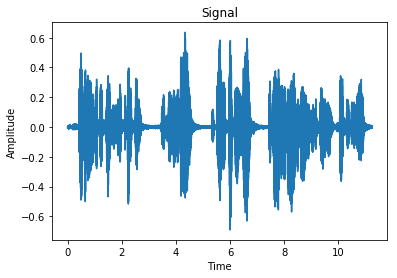

In [10]:
signal, samplerate = sf.read('jfk_moon.wav')
plot_signal(signal, samplerate)

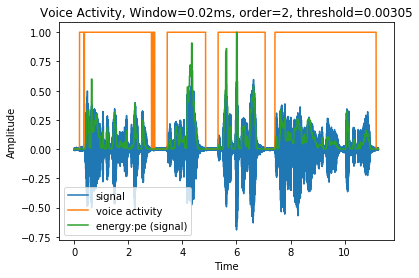

In [12]:
plot_pe_vad(signal, samplerate, window, threshold, order)

The yellow line indicates voice detected (1) or no voice detected (0). The actual value for the signal's energy:PE ratio is plotted in green, though it is scaled to fit on the graph, so does not represent the actual values. Window size, threshold, and order are all knobs you can play with. to smooth out the voice activity inidcator, or reduce false positives.

## Noisy Audio

Let's see how the entropy VAD holds up to some noise.

### White Noise

White noise is the go-to additive noise in the signal processing world. It is uniformly distributed across the frequency range, which is great if you're trying to model a communications channel, but not so good if you're trying to model, say, a speaker talking above others.

In [13]:
!play jfk_moon_white_15.wav


jfk_moon_white_15.wav:

 File Size: 180k      Bit Rate: 128k
  Encoding: Signed PCM    
  Channels: 1 @ 16-bit   
Samplerate: 8000Hz       
Replaygain: off         
  Duration: 00:00:11.25  

In:100%  00:00:11.25 [00:00:00.00] Out:90.0k [      |      ] Hd:3.4 Clip:0    
Done.


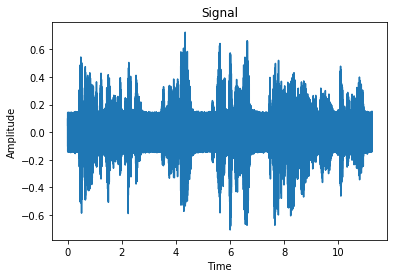

In [14]:
signal, samplerate = sf.read('jfk_moon_white_15.wav')
plot_signal(signal, samplerate)

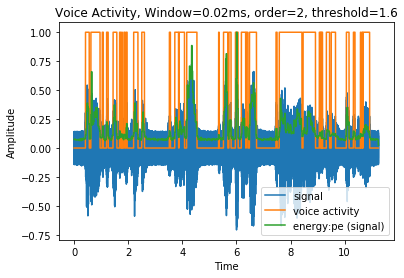

In [15]:
plot_pe_vad(signal, samplerate, window, threshold, order)

### Pink Noise

Pink noise concentrates more of its energy in the lower frequencies. This is a better model for a speaker talking above others.

In [16]:
!play jfk_moon_pink_15.wav


jfk_moon_pink_15.wav:

 File Size: 180k      Bit Rate: 128k
  Encoding: Signed PCM    
  Channels: 1 @ 16-bit   
Samplerate: 8000Hz       
Replaygain: off         
  Duration: 00:00:11.25  

In:100%  00:00:11.25 [00:00:00.00] Out:90.0k [      |      ]        Clip:0    
Done.


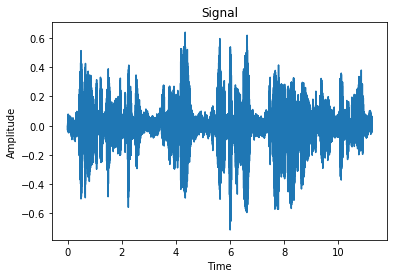

In [17]:
signal, samplerate = sf.read('jfk_moon_pink_15.wav')
plot_signal(signal, samplerate)

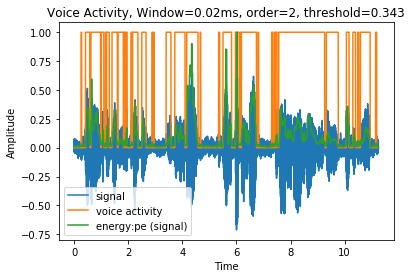

In [18]:
plot_pe_vad(signal, samplerate, window, threshold, order)

### Brownian Noise

Brownian noise concentrates even more of its energy in the lower frequencies than pink noise.

In [19]:
!play jfk_moon_brownian_15.wav


jfk_moon_brownian_15.wav:

 File Size: 180k      Bit Rate: 128k
  Encoding: Signed PCM    
  Channels: 1 @ 16-bit   
Samplerate: 8000Hz       
Replaygain: off         
  Duration: 00:00:11.25  

In:100%  00:00:11.25 [00:00:00.00] Out:90.0k [      |      ]        Clip:0    
Done.


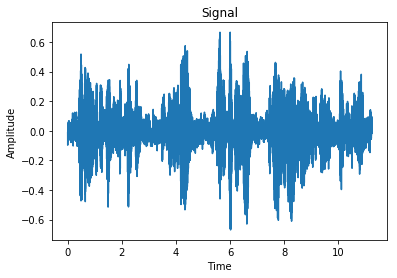

In [20]:
signal, samplerate = sf.read('jfk_moon_brownian_15.wav')
plot_signal(signal, samplerate)

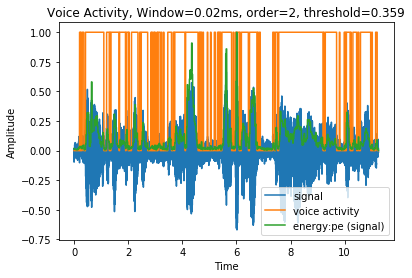

In [21]:
plot_pe_vad(signal, samplerate, window, threshold, order)

## Conclusions

Permutation entropy is a viable, lightweight measure for voice activity detection. Its performance in noise is as good, or better than contemporary techniques, without the computation penalty. As such, it is suitable for use in real-time applications and on low-power platforms.

2.0


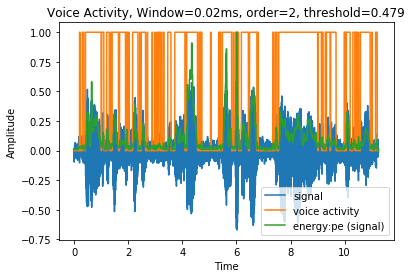

2.0


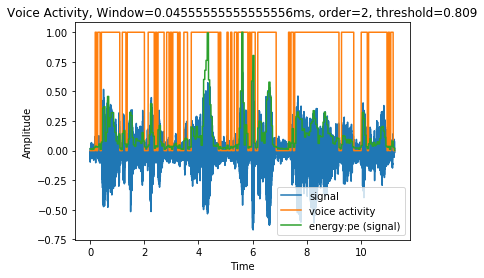

2.0


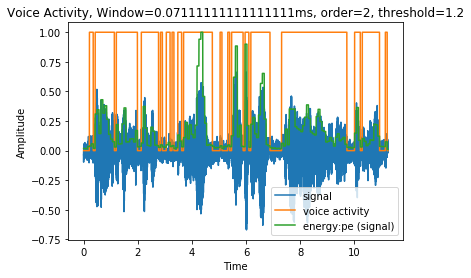

2.0


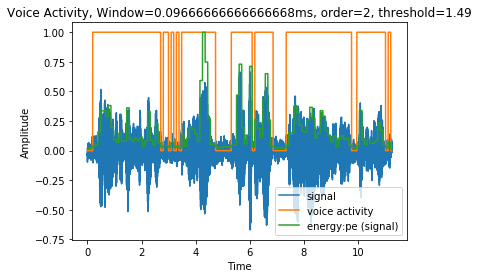

2.0


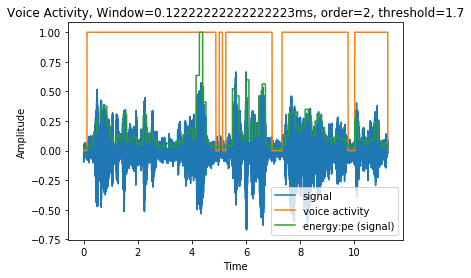

2.0


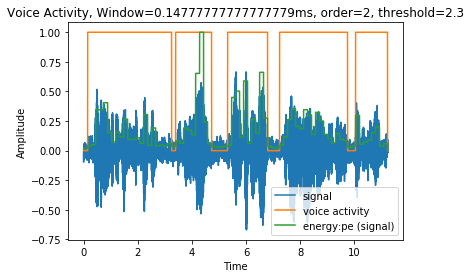

2.0


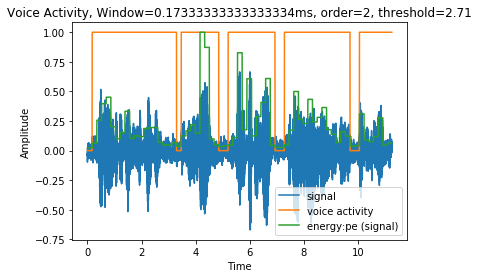

2.0


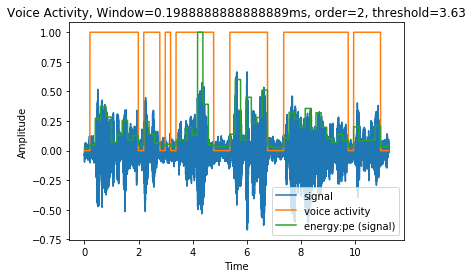

2.0


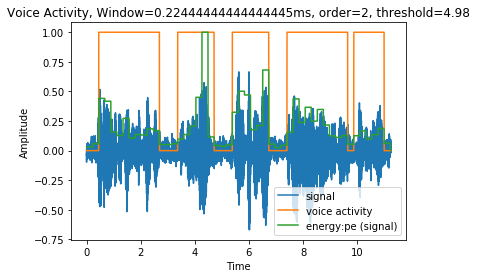

2.0


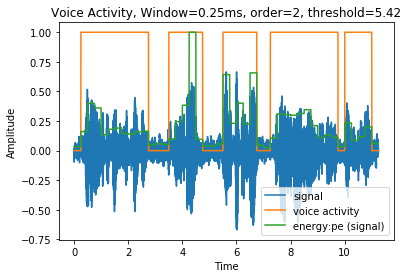

In [23]:
for window in np.linspace(0.02, 0.25, 10):
    plot_pe_vad(signal, samplerate, window, threshold, order)

## References

C. Bandt, B. Pompe, "Permutation entropy -- a natural complexity measure for time series", Physical Review Letters, vol 88, no 17, pp. 174102.1 - 174102.4, 2002.

N. Xu, C. Wang, J. Bao, "Voice Activity Detection Using Entropy-Based Method", in ICSPCS, 2015.

R. Ziemer, W. Tranter, "Principles of Communication, Systems, Modulation, and Noise, Third Edition", Boston: Houghton Mifflin, 1990. pp. 677-678.

J. Kennedy, "Special Message to the Congress on Urgent National Needs", Washington D.C., 1961. Available at https://archive.org/details/jfks19610525